# Imports

In [1]:
from components.models.utils import train_test_split
from components.datasets.dataset_factory import dataset_factory
from components.datasets.dataset_enum import Dataset
from components.text_handler.embedding.embedding_enum import EmbeddingType
from components.text_handler.embedding.embedding_factory import embedding_factory
import torch
import numpy as np
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
from components.models.algorithms.feed_nn_model import feed_model, LOSS, TRAIN, TEST, F1_SCORE, RECALL, PRECISION
from tqdm import tqdm
import os
from torch import nn
from components.models.algorithms.gru import GRU
from torchmetrics import Precision, Recall, F1Score
from matplotlib import pyplot as plt


# Define globals:

In [2]:
input_size = 100
output_size = 28 # we have 28 labels
hidden_size = 64
learning_rate = 4e-4
batch_size = 24
num_epochs = 10

# Load dataset:

In [3]:
embedding = embedding_factory(EmbeddingType.GLOVE)
dataset = dataset_factory(Dataset.GO_EMOTIONS, embedding)
train_dataset_data, test_dataset_data, train_dataset_labels, test_dataset_labels = train_test_split(dataset, 0.8)
train_size = len(train_dataset_data)
test_size = len(test_dataset_data)

# Define data loaders

In [4]:

train_dataset_labels = torch.from_numpy(np.array(train_dataset_labels)).long()
test_dataset_labels = torch.from_numpy(np.array(test_dataset_labels)).long()
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_dataset_data), train_dataset_labels.float())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_dataset_data), test_dataset_labels.float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

# Create model:

In [5]:
from components.models.algorithms.lstm import LSTM

dirname = os.path.dirname("__file__")
saved_data_path = os.path.join(dirname, "components")
saved_data_path = os.path.join(saved_data_path, "models")
saved_data_path = os.path.join(saved_data_path, "saved_models")
device = torch.device('cpu')

# model = GRU(input_size, output_size, hidden_size).to(device)
model = LSTM(input_size, output_size, hidden_size)
PATH = os.path.join(saved_data_path, f"{model.get_model_name()}.pth")
if os.path.exists(PATH):
    model.load_state_dict(torch.load(PATH))

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define metrics objects:

In [6]:
recall = Recall().to(device)
f1 = F1Score().to(device)
precision = Precision().to(device)

# Train model:

In [7]:
measurements = {
    LOSS: {TRAIN: [], TEST: []},
    RECALL: {TRAIN: [], TEST: []},
    F1_SCORE: {TRAIN: [], TEST: []},
    PRECISION: {TRAIN: [], TEST: []}
}

for epoch in tqdm(range(num_epochs)):

    # train the model
    model.train()
    feed_model(model, train_loader, criterion, optimizer, recall, f1, precision, measurements, TRAIN)

    # test the model
    model.eval()
    feed_model(model, test_loader, criterion, optimizer, recall, f1, precision, measurements, TEST)

    torch.save(model.state_dict(), PATH)

100%|██████████| 10/10 [1:50:42<00:00, 664.21s/it]


# Plot results:

Plotting results:

            train    test
loss       0.0655  0.0672
recall     0.4999  0.4986
F1 score   0.6135  0.6095
precision  0.8095  0.7984


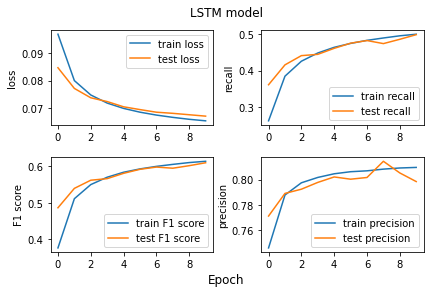

In [8]:
import pandas as pd

result_df = pd.DataFrame({
    TRAIN: {
        LOSS: 0.0,
        RECALL: 0.0,
        F1_SCORE: 0.0,
        PRECISION: 0.0
    },
    TEST: {
        LOSS: 0.0,
        RECALL: 0.0,
        F1_SCORE: 0.0,
        PRECISION: 0.0
    }
})

if len(measurements[LOSS][TRAIN]):
    print("Plotting results:\n")
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    subplots = [ax1, ax2, ax3, ax4]
    fig.suptitle(f'{model.get_model_name()} model')
    for index, (measurement_key, measurement) in enumerate(measurements.items()):
        result_df[TRAIN][measurement_key] = measurement[TRAIN][-1]
        result_df[TEST][measurement_key] = measurement[TEST][-1]
        subplot = subplots[index]
        subplot.plot(measurement[TRAIN], label=f'train {measurement_key}')
        subplot.plot(measurement[TEST], label=f'test {measurement_key}')
        subplot.set_ylabel(measurement_key)
        subplot.legend()
    fig.supxlabel('Epoch')
    plt.savefig(f'{model.get_model_name()}.png', dpi=300)
    plt.plot()
    result_df = result_df.round(4)
    print(result_df)
    result_df.to_csv(f'{model.get_model_name()}.csv')
else:
    print("You didn't run the training step!")